In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#default_exp beat_fit

In [ ]:
#export
import mido

import random
import math
from fastcore.basics import patch
from fractions import Fraction

In [ ]:
from fastcore.test import test_fail, test_close
from genetic_musical_generator.utility import hear
from genetic_musical_generator.random_genome_to_midi import random_genome, genome2midi

In [ ]:
g = random_genome(40)

In [ ]:
hear('DUFBFSDBBDBFUSSSSFDUSSDUUUSFSFFSBBSBBFSU')

DUFBFSDBBDBFUSSSSFDUSSDUUUSFSFFSBBSBBFSU


In [ ]:
lead = genome2midi('DUFBFSDBBDBFUSSSSFDUSSDUUUSFSFFSBBSBBFSU')
lead

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=60, velocity=64, time=480),
    Message('note_off', channel=0, note=60, velocity=64, time=480),
    Message('note_off', channel=0, note=61, velocity=64, time=0),
    Message('note_off', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_off', channel=0, note=61, velocity=64, time=960),
    Message('note_off', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=960),
    Message('note_off', channel=0, note=61, velocity=64, time=960)])
])

We are going to use simulated annealing to fit a pulse to the generated midi



    Let s = s0
    For k = 0 through kmax (exclusive):
        T ← temperature( 1 - (k+1)/kmax )
        Pick a random neighbour, snew ← neighbour(s)
        If P(E(s), E(snew), T) ≥ random(0, 1):
            s ← snew
    Output: the final state s



In [ ]:
#export
def primefactors(n):
    while (n % 2 == 0):
        yield 2
        n //= 2
    p = 3
    while p*p <= n:
        while (n % p == 0):
            yield p
            n //= p
        p += 2
    if n > 2:
        yield n
    while True:
        yield 1

In [ ]:
pf = primefactors(7)
assert next(pf) == 7
assert next(pf) == 1
assert next(pf) == 1

In [ ]:
from functools import reduce

In [ ]:
larger_primes = (73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173)
len(larger_primes)

20

In [ ]:
20/2/5 == 20//2//5

True

In [ ]:
mult = lambda it: reduce(lambda a,b: a*b, it)

In [ ]:
mult([3,4])

12

In [ ]:
mult(larger_primes[0:2])/73

79.0

In [ ]:
pf = primefactors(mult(larger_primes[0:4]))
assert next(pf) == 73
assert next(pf) == 79
assert next(pf) == 83
assert next(pf) == 89
assert next(pf) == 1

In [ ]:
lp = larger_primes

pf = primefactors(mult(lp))

for p in lp:
    npf = next(pf)
    assert npf == p, f'Next prime factor was {npf} but should have been {p}'
    
assert next(pf) == 1

In [ ]:
#export
def FracHalves():
    yield Fraction(1,1)
    fh = [Fraction(1,1)]
    fc = Fraction(1,2)
    while True:
        newf = []
        for f in fh:
            new = f - fc
            yield new
            newf.append(new)
            
        fc *= Fraction(1,2)
        fh.extend(newf)

In [ ]:
fh = FracHalves()
assert next(fh) == 1
assert next(fh) == Fraction(1,2)
assert next(fh) == Fraction(3,4)
assert next(fh) == Fraction(1,4)
assert next(fh) == Fraction(7,8)
assert next(fh) == Fraction(3,8)
assert next(fh) == Fraction(5,8)

In [ ]:
#export
class Offset(Fraction):
    def __new__(cls, *args):
        f = Fraction(*args)
        return Fraction.__new__(cls, f.numerator%f.denominator, f.denominator)
    
    def __lt__(self, other):
        if self.denominator != other.denominator:
            self_pf = primefactors(self.denominator)
            other_pf = primefactors(other.denominator)
            while True:
                sp = next(self_pf)
                op = next(other_pf)
                if sp != op:
                    return sp < op
        else:
            fh = FracHalves()
            vd = [Fraction(i,self.denominator) for i in range(self.denominator)]
            while True:
                nfh = next(fh)
                nf = [v for v in vd if v < nfh][-1]
                if nf == self: return True
                if nf == other: return False

In [ ]:
assert Offset(2,7) == Offset(2,7)
assert Offset(8,7) == Offset(1,7)

assert Offset(Fraction(2,7)) == Offset(Fraction(2,7))
assert Offset(Fraction(8,7)) == Offset(Fraction(1,7))

assert Offset(0) == 0

assert Offset(-1,7) == Offset(6,7)

In [ ]:
assert next(primefactors(1)) == 1
assert next(primefactors(2)) == 2
assert next(primefactors(3)) == 3

In [ ]:
pf = primefactors(Offset(0,1).denominator)
assert next(pf) == 1
assert next(pf) == 1

In [ ]:
pf = primefactors(Offset(1,2).denominator)
assert next(pf) == 2
assert next(pf) == 1

In [ ]:
assert Offset(0,1) < Offset(1,2)
assert Offset(1,2) < Offset(1,3)
assert Offset(7,8) < Offset(2,3)
assert Offset(4,5) < Offset(1,5)
assert Offset(6,7) < Offset(3,7)
assert Offset(3,7) < Offset(5,7)

In [ ]:
#export
class BeatFit:
    def __init__(self, lead=None):
        if lead is not None:
            if not isinstance(lead, mido.MidiFile) or lead.type != 0:
                raise ValueError("Lead part must be a type 0 mido.MidiFile")
            self.onsets = BeatFit.note_starts(lead)
            # check lead contains at least two differing note starts
            if len(set(self.onsets)) < 2:
                raise ValueError("Lead part must contain at least two notes with differing start times")

        self.lead = lead

        self._input_tempo = None
        self.fitted_state = None
        self.loss_map = []
    
    def fit(self, iterations=100):
        state = self.random_state()
        for iteration in range(iterations):
            temp = self.temperature(iteration/iterations)
            next_state = self.neighbour(state)
            state_loss, next_state_loss = self.losses(state, next_state)
            if next_state_loss < state_loss or random.uniform(0,1) < math.exp((state_loss-next_state_loss)/temp):
                state = next_state
        
        self.fitted_state = state

In [ ]:
[o for o in lead.tracks[0]]

[Message('note_on', channel=0, note=61, velocity=64, time=0),
 Message('note_on', channel=0, note=61, velocity=64, time=0),
 Message('note_on', channel=0, note=60, velocity=64, time=480),
 Message('note_off', channel=0, note=60, velocity=64, time=480),
 Message('note_off', channel=0, note=61, velocity=64, time=0),
 Message('note_off', channel=0, note=61, velocity=64, time=0),
 Message('note_on', channel=0, note=61, velocity=64, time=0),
 Message('note_on', channel=0, note=61, velocity=64, time=0),
 Message('note_off', channel=0, note=61, velocity=64, time=960),
 Message('note_off', channel=0, note=61, velocity=64, time=0),
 Message('note_on', channel=0, note=61, velocity=64, time=960),
 Message('note_off', channel=0, note=61, velocity=64, time=960)]

In [ ]:
c = lead.tracks[0]
assert c is lead.tracks[0]

In [ ]:
#export
@patch(cls_method=True)
def note_starts(cls:BeatFit, lead):
    output = []
    pos = 0
    track = lead.tracks[0]
    ppq = lead.ticks_per_beat
    for m in track:
        if m.type == 'note_on':
            output.append(Fraction(pos, ppq))
        pos += m.time
    
    return output

In [ ]:
assert len(set(BeatFit.note_starts(lead))) > 1

In [ ]:
failer = genome2midi('UDFBBS')
failer

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('note_on', channel=0, note=60, velocity=64, time=0),
    Message('note_off', channel=0, note=60, velocity=64, time=480)])
])

In [ ]:
def _fail(): raise ValueError("foobar")
test_fail(_fail, contains="oba")

In [ ]:
test_fail(lambda: BeatFit(failer), contains="differ")

In [ ]:
del failer

In [ ]:
mido.tempo2bpm(500000)

120.0

In [ ]:
#export
@patch(as_prop=True)
def input_tempo(self:BeatFit):
    if self._input_tempo is None:
        self._input_tempo = mido.tempo2bpm(500000)
        for msg in self.lead:
            # we assume just one tempo, so take the last one in the file
            if msg.type == 'set_tempo':
                self._input_tempo = mido.tempo2bpm(msg.tempo)
    return self._input_tempo

In [ ]:
t = genome2midi('SUDFBBS')
t

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('note_on', channel=0, note=60, velocity=64, time=0),
    Message('note_off', channel=0, note=60, velocity=64, time=480),
    Message('note_on', channel=0, note=60, velocity=64, time=0),
    Message('note_off', channel=0, note=60, velocity=64, time=480)])
])

In [ ]:
t.tracks[0].insert(0, mido.MetaMessage('set_tempo', tempo=mido.bpm2tempo(140)))

In [ ]:
t

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=428571, time=0),
    Message('note_on', channel=0, note=60, velocity=64, time=0),
    Message('note_off', channel=0, note=60, velocity=64, time=480),
    Message('note_on', channel=0, note=60, velocity=64, time=0),
    Message('note_off', channel=0, note=60, velocity=64, time=480)])
])

In [ ]:
beatfit = BeatFit(t)
test_close(beatfit.input_tempo, 140, eps=1e-3)

Given note starts $a$ and $b$, new and old tempos are related by the divisor between those note points by

$$ \frac{1}{\text{bpm}} = \frac{1}{\text{bpm}_{orig}} \cdot \frac{(b-a)}{\text{div}}. $$

So to calculate the divisor for the tempo we wish to have we can use

$$ \text{div} = \frac{\text{bpm}}{\text{bpm}_{orig}} \cdot (b-a). $$

In [ ]:
#export
@patch
def closest_div(self:BeatFit, a, b, targ_tempo, old_tempo=None):
    if old_tempo is None:
        old_tempo = self.input_tempo
    return max(1, round(targ_tempo * (b-a) / old_tempo))

In [ ]:
#export
@patch
def random_state(self:BeatFit, bpm_min=40, bpm_max=280):
    a,b = tuple(random.sample(list(set(self.onsets)), 2))
    
    if a > b: a,b = b,a
        
    # choose a random tempo uniformly bewteen min and max
    targ_tempo = random.uniform(bpm_min, bpm_max)
    
    # calculate the appropriate divisor to reach tempo, but use at least one
    div = self.closest_div(a,b,targ_tempo)
    
    return a, b, div

In [ ]:
beatfit = BeatFit(lead)
beatfit.random_state()

(Fraction(0, 1), Fraction(2, 1), 3)

In [ ]:
#export
@patch
def temperature(self:BeatFit, p):
    return math.exp(-5 * p)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

Bad value in file '/Users/leoauri/.matplotlib/matplotlibrc', line 1 ('backend: Qt4Cairo'): Key backend: 'qt4cairo' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


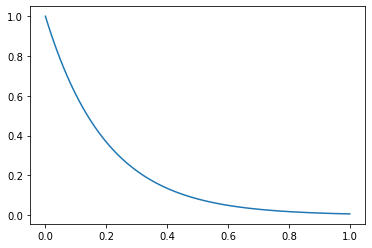

In [ ]:
beatfit = BeatFit(lead)
x = np.linspace(0,1,100)
y = list(map(beatfit.temperature, x))

plt.plot(x,y)

$$ \text{div}_{new} \simeq \frac{\text{div} \cdot (b-a_{new})}{b-a} $$

In [ ]:
#export
@patch
def neighbour(self:BeatFit, state):
    a,b,div = state

    opts = list(set(self.onsets) - {a,b})
    
    def trans_a(a,b,div):
        a_new = random.choice(opts)
        div_new = max(1, round(div * abs(b-a_new) / abs(b-a)))
        return a_new, b, div_new
    def trans_b(a,b,div): 
        b,a,div = trans_a(b,a,div)
        return a,b,div
    trans_div = lambda a,b,div: (a, b, 2 if div == 1 else div + random.choice([-1,1]))
        
    if len(opts) < 1:
        return trans_div(a,b,div)
    
    trans = random.choice([trans_a, trans_b, trans_div])
    a,b,div = trans(a,b,div)
    if a > b: a,b = b,a
    return a,b,div

In [ ]:
beatfit = BeatFit(lead)
assert all([beatfit.neighbour((Fraction(0, 1), Fraction(2, 1), 4))[2] > 2 for _ in range(20)])

**THIS CALCULATES TRANFORMATION**

In [ ]:
#export
@patch
def transformed_onsets(self:BeatFit, state):
    a,b,div = state
    assert a < b
    return [(n-a) * div / (b-a) for n in self.onsets]

@patch
def offsets(self:BeatFit, state):
    return [Offset(n) for n in self.transformed_onsets(state)]

In [ ]:
#export
@patch
def tempo(self:BeatFit, state=None):
    if state is None:
        state = self.fitted_state
    a,b,div = state
    assert a < b
    return self.input_tempo * div / (b-a)

In [ ]:
#export
@patch
def losses(self:BeatFit, state, next_state):
    # update losses map with offsets from states
    self.loss_map = sorted(list(set(self.loss_map)|set(self.offsets(state))|set(self.offsets(next_state))))
    # map offsets to losses, add tempo loss
    offs_lossf = lambda state: sum([self.loss_map.index(o) for o in self.offsets(state)])
    tempo_lossf = lambda state: math.exp((self.tempo(state)-280)/4)
    state_loss = offs_lossf(state) + tempo_lossf(state)
    next_state_loss = offs_lossf(next_state) + tempo_lossf(next_state)
    return state_loss, next_state_loss

In [ ]:
beatfit = BeatFit(lead)
beatfit.fit()
beatfit.fitted_state

(Fraction(2, 1), Fraction(4, 1), 3)

In [ ]:
beatfit.tempo(beatfit.fitted_state)

180.0

In [ ]:
#export
from dataclasses import dataclass
from math import floor, ceil

@dataclass
class NoteOn:
    pitch: int
    time: Fraction
        
@dataclass
class NoteOff:
    pitch: int
    time: Fraction

@patch(as_prop=True)
def complete(self:BeatFit):
    ppq = self.lead.ticks_per_beat
    lead_frac = []
    pos = 0
    for m in self.lead.tracks[0]:
        pos += m.time
        if m.type == 'note_on':
            lead_frac.append(NoteOn(m.note, Fraction(pos, ppq)))
        if m.type == 'note_off':
            lead_frac.append(NoteOff(m.note, Fraction(pos, ppq)))
        
    a,b,div = self.fitted_state
    
    transformed_events = []
    for e in lead_frac:
        time = (e.time-a) * div / (b-a)
        transformed_events.append(NoteOn(e.pitch, time) if isinstance(e, NoteOn) else NoteOff(e.pitch, time))
        
    anacrusis = floor(transformed_events[0].time) - 4
    length = ceil(transformed_events[-1].time) - anacrusis
    
    hihathit = [mido.Message('note_on', note=42, channel=9, time=0), 
                mido.Message('note_off', note=42, channel=9, time=ppq)]
    
    midifile = mido.MidiFile(type=1)
    
    pulse = mido.MidiTrack()
    midifile.tracks.append(pulse)
    
    # append tempo to pulse track
    pulse.append(mido.MetaMessage('set_tempo', tempo=mido.bpm2tempo(self.tempo())))
    pulse.extend(hihathit*length)
    
    trasf_lead = mido.MidiTrack()
    midifile.tracks.append(trasf_lead)

    pos = anacrusis
    for te in transformed_events:
        trasf_lead.append(mido.Message('note_on' if isinstance(te, NoteOn) else 'note_off', note=te.pitch, 
                                       time=round((te.time-pos)*ppq)))
        pos = te.time

    return midifile

In [ ]:
beatfit.lead

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=60, velocity=64, time=480),
    Message('note_off', channel=0, note=60, velocity=64, time=480),
    Message('note_off', channel=0, note=61, velocity=64, time=0),
    Message('note_off', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=0),
    Message('note_off', channel=0, note=61, velocity=64, time=960),
    Message('note_off', channel=0, note=61, velocity=64, time=0),
    Message('note_on', channel=0, note=61, velocity=64, time=960),
    Message('note_off', channel=0, note=61, velocity=64, time=960)])
])

In [ ]:
beatfit.complete

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=333333, time=0),
    Message('note_on', channel=9, note=42, velocity=64, time=0),
    Message('note_off', channel=9, note=42, velocity=64, time=480),
    Message('note_on', channel=9, note=42, velocity=64, time=0),
    Message('note_off', channel=9, note=42, velocity=64, time=480),
    Message('note_on', channel=9, note=42, velocity=64, time=0),
    Message('note_off', channel=9, note=42, velocity=64, time=480),
    Message('note_on', channel=9, note=42, velocity=64, time=0),
    Message('note_off', channel=9, note=42, velocity=64, time=480),
    Message('note_on', channel=9, note=42, velocity=64, time=0),
    Message('note_off', channel=9, note=42, velocity=64, time=480),
    Message('note_on', channel=9, note=42, velocity=64, time=0),
    Message('note_off', channel=9, note=42, velocity=64, time=480),
    Message('note_on', channel=9, note=42, velocity=64, time=0),
    Message('note_off', c

In [ ]:
#export
outport = mido.open_output('mido_out', virtual=True)

def play(midifile):
    for m in midifile.play():
        outport.send(m)

In [ ]:
play(beatfit.lead)

In [ ]:
play(beatfit.complete)